## Link to Github Repository: 
[Github Repo](https://github.com/daisywatters/PIC-16B-Project)

## Project Overview

Hello and welcome to our Pic 16B Final Project! Our names are Daisy and Michelle, and we are both third year Cognitive Science Majors with a Specialization in Computing. In our Pic 16B Final Project, we aim to address the problem that many high school students have of deciding where they should apply to college. Since both of us went through the difficult process of college applications, we understand that it can be confusing and stressful to decide how many colleges to apply to, which colleges are “reach”, “target”, and “safety”, and whether the colleges you plan to apply to will fit what you are looking for in terms of location, social atmosphere, and academics. Therefore, this project aims to solve those stressors, by having a student input their GPA, preferred location of study (by region), preference of private versus public university, and number of students per class. Then, our project will evaluate through a data frame of all four year universities in the U.S. (we scraped this data from the web and also utilized data frames that already had the required information) and return the universities that fit those criteria. The **technical components** of this project will include: **utilizing web scraping tools, high level plot visualizations, and building a dynamic website with user-inputted information.** 

This project certainly came with its challenges, as neither of us had prior experience with web scraping or website creation besides what we discussed in class. However, with the help of our professor, TA, our peers, and the bountiful resources on the Internet, we were able to design an aesthetic website that combined all of our initial goals for this project. We are overall very happy with the outcome of our project, although we would say that if we had the chance to do this project again, we definitely would have wanted to use more data. However, this issue is simply due to the fact that not every college has their statistics readily available on the Internet. 

In this blog post, we will walk you through each step of our project creation, using code snippets and figures to illustrate the process. We hope you enjoy!

## Flowchart of Project Logic

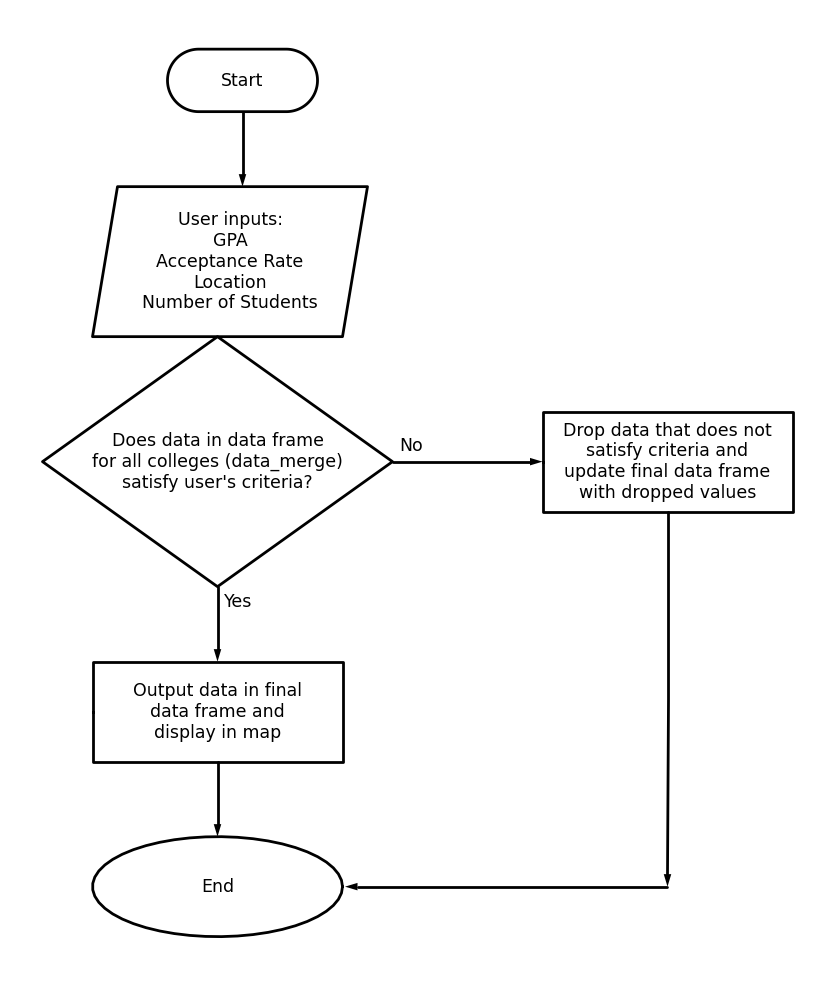

In [1]:
import schemdraw
from schemdraw.flow import *
with schemdraw.Drawing() as d:
    d += Start().label("Start")
    d += Arrow().down(d.unit/2)
    d += Data(h = 3, w = 5).label("User inputs:\nGPA\nAcceptance Rate\nLocation\nNumber of Students")
    
    
    # Check if data in data_merge satisfies user's inputted criteria
    d+= (decision := Decision(w = 7, h= 5,
                       S = "Yes",
                        E = "No").label("Does data in data frame\nfor all colleges (data_merge)\nsatisfy user's criteria?"))
    
    # If Yes
    d+= Arrow().length(d.unit/2)
    d+= (true := Box(w = 5).label("Output data in final\ndata frame and\ndisplay in map"))
    d+= Arrow().length(d.unit/2)
    
    # End program
    d+= (end := Ellipse(w = 5).label("End"))
    
    # If No: new arrow
    d+= Arrow().right(d.unit).at(decision.E)
    
    # In "False" box write "Drop data that does not satisfy criteria and display final data frame and map"
    d+= (false := Box(w = 5).label("Drop data that does not\nsatisfy criteria and\nupdate final data frame\nwith dropped values"))
    d+= Arrow().down(d.unit*2.5).at(false.S)
    
    # Then end program
    d+= Arrow().left(d.unit*2.15)


The first step is to import necessary packages. We will use `Pandas`, `NumPy` and `Plotly` for various data manipulation and plotting techniques.

In [2]:
import pandas as pd
import numpy as np
from plotly import express as px
from plotly.io import write_html
import plotly.io as pio
pio.renderers.default="iframe"

## 1. Data Preparation

One of the most important parts of this project was collecting the necessary college data to both find colleges based on user preference AND output information users would be interested in. In order to get a comprehensive data frame of U.S. colleges and their statistics, we had to pull from two different sources.

### Read in US Colleges and Universities data from opendatasoft

The first place we pulled data from was [opendatasoft](https://public.opendatasoft.com/explore/dataset/us-colleges-and-universities/table/?flg=en-us), a website with a ready made data frame containing over 6000 colleges in the U.S. and US territories. All we had to do to get this data was read in the file using pandas. Daisy was in charge of extracting the data from Opendatasoft.

In [3]:
df = pd.read_json("us-colleges-and-universities.json")

We can take a look at this data frame below!

In [4]:
df.head()

,geo_point_2d,geo_shape,objectid,ipedsid,name,address,city,state,zip,zip4,...,alias,size_set,inst_size,pt_enroll,ft_enroll,tot_enroll,housing,dorm_cap,tot_emp,shelter_id
0,"{'lon': -81.36768715399995, 'lat': 28.57614169...","{'type': 'Feature', 'geometry': {'coordinates'...",11,133872,ADVENTHEALTH UNIVERSITY,671 WINYAH DRIVE,ORLANDO,FL,32803,NOT AVAILABLE,...,FLORIDA HOSPITAL COLLEGE,26,2,1032,770,1802,1,174,457,NOT AVAILABLE
1,"{'lon': -80.09219037499997, 'lat': 26.54285726...","{'type': 'Feature', 'geometry': {'coordinates'...",59,487445,FLORIDA CAREER COLLEGE-BOYNTON BEACH,1743 NORTH CONGRESS AVENUE,BOYNTON BEACH,FL,33426,8205,...,NOT AVAILABLE,-2,1,-999,681,681,2,-999,42,NOT AVAILABLE
2,"{'lon': -95.44840231499995, 'lat': 30.01314587...","{'type': 'Feature', 'geometry': {'coordinates'...",75,450711,TREND BARBER COLLEGE,14806 ELLA BLVD.,HOUSTON,TX,77090,NOT AVAILABLE,...,NOT AVAILABLE,-2,1,-999,74,74,2,-999,13,NOT AVAILABLE
3,"{'lon': -74.96301849199995, 'lat': 40.13962069...","{'type': 'Feature', 'geometry': {'coordinates'...",90,443784,STRAYER UNIVERSITY-PENNSYLVANIA,3800 HORIZON BLVD STE 100,TREVOSE,PA,19053,NOT AVAILABLE,...,NOT AVAILABLE,19,2,2040,150,2190,2,-999,-999,NOT AVAILABLE
4,"{'lon': -75.00528053499994, 'lat': 39.88022055...","{'type': 'Feature', 'geometry': {'coordinates'...",122,486734,JOLIE HEALTH & BEAUTY ACADEMY-CHERRY HILL,1490 BERLIN RD STE 21,CHERRY HILL,NJ,8003,NOT AVAILABLE,...,NOT AVAILABLE,-2,1,14,62,76,2,-999,9,NOT AVAILABLE


The last step for this data set was to clean it for future merging purposes, and so it contains only the data we are interested in. In this case we only wanted the college names and locations.

In [5]:
def prepare_df(df):
    '''Returns a cleaned data frame
    Parameters: 
        df: the data frame to be cleaned
    Type: 
        df: two dimensional data structure
    Return: a cleaned data frame
    '''
    # selects only the columns we want to look at
    df = df[["geo_point_2d","name", "city", "state", "country", "website"]]
    # renames "name" column to "College" for future data merging purposes
    df = df.rename(columns={"geo_point_2d":"Coordinates", "name": "College", "city":"City", "state":"State", "country":"Country", "website":"Website"})
    
    # turns columns from all caps to having only first letter of each word capitalized
    df["College"] = df["College"].apply(lambda x: x.title())
    df["City"] = df["City"].apply(lambda x: x.title())
    
    # finds index of rows in df where colleges are not in the US
    not_USA_colleges = df[(df['Country'] != 'USA')].index 
    
    # Delete these row indexes from dataFrame
    df = df.drop(not_USA_colleges)
    
    # makes every website link https for later user functionality purposes
    new_websites = [] # empty list
    # loops through each website in dataframe
    # if the website does not already start with "https://" this will be added to start of link
    for website in df["Website"]:
        if (website.startswith("https://") == False) and (website.startswith("NOT") == False):
            website = 'https://' + website
            new_websites.append(website)
        else:
            new_websites.append(website)
    # "Website" column of dataframe is updated with https websites
    df["Website"] = new_websites 
    
    return(df)

This is what the final cleaned data frame looks like.

In [6]:
colleges_locations = prepare_df(df)
colleges_locations.head()

,Coordinates,College,City,State,Country,Website
0,"{'lon': -81.36768715399995, 'lat': 28.57614169...",Adventhealth University,Orlando,FL,USA,https://www.ahu.edu/
1,"{'lon': -80.09219037499997, 'lat': 26.54285726...",Florida Career College-Boynton Beach,Boynton Beach,FL,USA,https://www.floridacareercollege.edu/
2,"{'lon': -95.44840231499995, 'lat': 30.01314587...",Trend Barber College,Houston,TX,USA,https://trendbarbercollege.com/
3,"{'lon': -74.96301849199995, 'lat': 40.13962069...",Strayer University-Pennsylvania,Trevose,PA,USA,https://www.strayer.edu/campus-locations/penns...
4,"{'lon': -75.00528053499994, 'lat': 39.88022055...",Jolie Health & Beauty Academy-Cherry Hill,Cherry Hill,NJ,USA,https://jolieacademy.com/


### Technical Component 1: Web Scraping Appily Website

The second place we pulled data from was [appily](https://www.appily.com/colleges/gpa), a college planning website that contains statistics for many colleges in the U.S. Michelle and Daisy collaborated for web scraping in this portion. We decided to use web scraping as one of our technical components because it was a concept that really interested us from class, especially after Homework 2, where we implemented Web Scraping to extract aspects of our favorite movie/TV show. We knew that the college data we were interested in like GPA, Acceptance Rate, Type of Institution, and Number of Students would most likely not be readily available in a dataset accessed through Kaggle or somewhere else. Therefore, web scraping was the most efficient approach, so we looked for websites that had information on each college's GPA, acceptance rate, etc. Appily was the website that fit our needs the best because it organized colleges by GPA, and then had a footer full of information for each of the colleges. By inspecting the page, we were able to easily pull the information out of the footer using a for loop for each college in the given page. We also had to loop through all the GPA links and yield a scrapy.Request, but this was made much easier by referencing the code we used for Homework 2. 

The most challenging part of the scraper was trying to extract the Type of Institution and Number of Students for each school, as shown in the `parse_stats` method below. This was because they did not have a class name more specific than "div.college-list--card-data-val", unlike GPA and Acceptance Rate. Therefore, we had to implement another for loop to check if the "div.college-list--card-data-label" was "type of institution" or "number of students" and then extract the corresponding "div.college-list--card-data-val". 

### Here is a screenshot of the Appily website we scraped from, where you can see how they organized colleges by GPA:
![](Screen%20Shot%202023-12-14%20at%206.31.42%20PM.png)


### This image shows the footer with information for each college:
![](Screen%20Shot%202023-12-14%20at%207.36.29%20PM.png)

We had to use a Scrapy spider to scrape the information we wanted into a csv file, and this csv along with all the other files used for the Scrapy spider are uploaded to our github. However, the functions implemented in `college_spider.py` are shown below.

To begin web scraping, we implemented a `parse` method. This method parses the starting url page that contains GPAs from 2.0 to 4.0, and navigates to the designated page for each GPA. Each of these GPA pages contains a list of colleges you would qualify for with the given GPA, and it also includes some of their statistics. 

```python

def parse(self, response):
        '''
        Meant to parse the starting url page with all the GPAs 
        Navigates to the designated page with links to colleges for the specified GPA
        Does not return any data
        '''    
        # URL for the specified GPA page          
        gpa_college_url = [gpa.attrib["href"] for gpa in response.css("div.view-content.view-row-count-1 div.item-list ul li div.views-field.views-field-title span.field-content a")]

        # loops through all GPA page links 
        for link in gpa_college_url:
            # loops through all additional pages under each GPA
            for i in range(5):   
                url = "https://www.appily.com" + link + "?page=" + str(i)
                i += 1
            # Yield scrapy.Request using the url for the specified GPA page
            yield scrapy.Request(url, callback = self.parse_stats)
```

The `parse_stats` method works by crawling through each college on the page of a given GPA, and yields the statistics we are interested in for each of these schools.

```python
def parse_stats(self, response):
        '''
        Meant to parse the page for all colleges of a given GPA
        Returns the average GPA and acceptance rate for each college
        '''

        # loops through each college on GPA page
        # scrapes college name, average gpa, acceptance rate, institution type, total number of undergrad
        for college in response.css("article.college-list--card.gpa-result"):  
            
            # extract college name
            college_name = college.css("div.college-list--card-head div.college-list--card-title-wrap div.college-list--card-title div.college-list--card-title-conatiner a::text").get()
            # extract gpa for the college
            gpa = college.css("div.college-list--card-footer div.college-list--card-outer div.college-list--card-inner div.college-list--card-data-val div.field.average-gpa::text").get()
            # extract acceptance rate for the college
            acceptance_rate = college.css("div.college-list--card-footer div.college-list--card-outer div.college-list--card-inner div.college-list--card-data-val div.field.acceptance-rate::text").get() 
            
            # use for loop to extract type of institution and number of students because they did not have more specific div values (like div.field.average-gpa for gpa)
            for match in college.css("div.college-list--card-footer div.college-list--card-outer div.college-list--card-inner"):       

                if match.css("div.college-list--card-data-label::text").get() == "type of institution":
                    type_institution = match.css("div.college-list--card-data-val::text").get()
                    
                if match.css("div.college-list--card-data-label::text").get() == "number of students":
                    num_students = match.css("div.college-list--card-data-val::text").get()
                    num_students = int(num_students.replace(",", ""))

            yield {"College" : college_name, 
                  "GPA" : gpa,
                  "Acceptance Rate" : acceptance_rate,
                  "Type of Institution" : type_institution,
                   # divide number of students by 4 to obtain approximate number of students per class
                  "Number of Students" : round(num_students/4)}
```

The final `colleges.csv` file containing all of the desired college information is read in below, and of colleges that appear multiple times in the data frame, only the first instance is kept. Let's take a look at the final output.

In [7]:
colleges_stats = pd.read_csv("colleges.csv")

In [8]:
colleges_stats = colleges_stats.drop_duplicates()
colleges_stats["College"] = colleges_stats["College"].apply(lambda x: x.title())
colleges_stats

,College,GPA,Acceptance Rate,Type of Institution,Number of Students
0,University Of New Mexico-Main Campus,3.4,97%,Public,5535
1,Grand Canyon University,3.2,83%,Private,25768
2,Marymount University,3.4,84%,Private,889
3,Colorado Mesa University,3.3,80%,Public,2227
4,Kean University,3.2,79%,Public,3190
...,...,...,...,...,...
3561,University Of South Florida-St Petersburg,3.7,27%,Public,1000
3569,Gustavus Adolphus College,3.7,73%,Private,563
3570,Lewis & Clark College,3.7,79%,Private,875
3571,Juniata College,3.7,74%,Private,322


### Merge Datasets

The final step of data preparation was to merge our two data frames and do any final data cleaning. Michelle and Daisy collaborated on this portion. 

In [9]:
data_merge = pd.merge(colleges_locations, colleges_stats, on='College')

In [10]:
# strips white space from any entries to avoid indexing issues later
data_merge["Type of Institution"] = data_merge["Type of Institution"].apply(lambda x: x.strip())

Let's take a look at our final data frame!

In [11]:
data_merge

,Coordinates,College,City,State,Country,Website,GPA,Acceptance Rate,Type of Institution,Number of Students
0,"{'lon': -81.36768715399995, 'lat': 28.57614169...",Adventhealth University,Orlando,FL,USA,https://www.ahu.edu/,3.2,90%,Private,417
1,"{'lon': -122.40068563799997, 'lat': 37.7877475...",Academy Of Art University,San Francisco,CA,USA,https://www.academyart.edu/,3.2,--,Private,1951
2,"{'lon': -84.473639, 'lat': 42.72476}",Michigan State University,East Lansing,MI,USA,https://www.msu.edu/,3.8,83%,Public,12415
3,"{'lon': -75.87803192899997, 'lat': 41.24888894...",King'S College,Wilkes-Barre,PA,USA,https://www.kings.edu/,3.3,96%,Private,532
4,"{'lon': -78.15837590299998, 'lat': 39.16605804...",Shenandoah University,Winchester,VA,USA,https://www.su.edu/,3.7,74%,Private,1072
...,...,...,...,...,...,...,...,...,...,...
1244,"{'lon': -122.48501577199994, 'lat': 48.7373785...",Western Washington University,Bellingham,WA,USA,https://wwu.edu/,3.5,96%,Public,3781
1245,"{'lon': -77.366199, 'lat': 35.606347}",East Carolina University,Greenville,NC,USA,https://www.ecu.edu/,3.3,94%,Public,7005
1246,"{'lon': -73.979502, 'lat': 40.753923}",Berkeley College-New York,New York,NY,USA,https://berkeleycollege.edu/,2.5,--,Private,495
1247,"{'lon': -71.08703049599995, 'lat': 42.34689548...",Berklee College Of Music,Boston,MA,USA,https://www.berklee.edu/,3.0,55%,Private,1986


## 2. Creating Website Output

Now that the data has been prepared, we can work on the functionality of our website and what will be outputted based on user input. We wanted the website to output both a map of the U.S. with recommended colleges, and a table that includes the links to each college's website. This means we had to write two functions, one for the table and one for the map. Michelle was responsible for writing both of the functions.

### Function to Output College Recommendations Table

First we worked on creating the function that will output a table with recommended colleges based on user input, because this will be used to later create the Plotly map.

In [12]:
# Function to output colleges based on user input

def college_recs(gpa_input, type_inst_input, size_input, location_input):    
    '''
    Input: 
    - gpa input (select one value from 2.0 to 4.0 incremented by 0.1)
    - type of institution input (select one or more from public, private)
    - size input (select one value from 0 to 500, 500 to 1,000, 1,000 to 5,000, 5,000 to 10,000, or 10,000+)
    - location input (select one or more from Northeast, Midwest, South, West)
    
    Output: 
    - data frame with values for gpa, type of institution, size, location corresponding to user's 
    inputted selections
    '''
    
    # dictionary containing all the states in a given region
    region_dict = {
        "Northeast": ["PA", "NY", "VT", "ME", "NJ", "CT", "RI", "MA"],
        "Midwest": ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "MI", "IN", "OH"],
        "South": ["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", "FL", "GA", "SC", "NC", "VA", "WV", "DE", "MD"],
        "West": ["AK", "HI", "WA", "OR", "CA", "AZ", "NM", "NV", "UT", "CO", "ID", "WY", "MT"]
    }
    
    # dictionary containing the tuples for a given size 
    size_dict = {
        "0 to 500 (Very Small)" : (0, 500),
        "500 to 1,000 (Small)" : (500, 1000),
        "1,000 to 5,000 (Medium)" : (1000, 5000),
        "5,000 to 10,000 (Large)" : (5000, 10000),
        "10,000+ (Very Large)" : (10000, 500000)
    }
    
    # list of states in the user's inputted region choice
    # for loop allows for multiple region selections
    states_in_region = []
    for region in location_input:
        states_in_region = states_in_region + region_dict[region]

    # assign lower size value to first value in size tuple
    # assign upper size value to second value in size tuple
    lowerbound, upperbound = size_dict[size_input]
    
    # initialize lists for latitude and longitude
    lat = []
    lon = []
    
    # loop through each row in data_merge data frame and extract the latitude and longitude for each college
    for i in range(0, data_merge.shape[0]):
        for key, value in data_merge["Coordinates"][i].items():
            if key == "lat":
                lat.append(value)
            if key == "lon":
                lon.append(value)
                
    # Create "Latitude" column and assign latitude for each college to it
    data_merge["Latitude"] = lat
    
    # Create "Longitude" column and assign longitude for each college to it
    data_merge["Longitude"] = lon
    
    # Drop "Coordinates" column from final data frame
    final_data = data_merge.drop(columns = ["Coordinates"])
    
    # Output GPA, Type of Institution, State, Number of Students, corresponding to user's 
    # inputted selections in the final data frame
    final_data = final_data[(data_merge["GPA"] <= gpa_input) & 
                            (data_merge["Type of Institution"].isin(type_inst_input)) & 
                            (data_merge["State"].isin(states_in_region)) &
                            (data_merge["Number of Students"] >= lowerbound) & 
                            (data_merge["Number of Students"] < upperbound)]
    
    # Reset index for final data frame
    final_data = final_data.reset_index()
    
    # Return final data frame
    return final_data
    

To demonstrate that the `college_recs` function is working, we can test it with some possible user inputs.

For this example, the user has a 3.5 GPA, no preference of public vs. private school, they want a large number of students in their grade level, and they want the school to be located in the West or Northeast regions. The function will output college recommendations based on these inputs.

In [13]:
college_result_df = college_recs(3.5,  ["Public", "Private"], "5,000 to 10,000 (Large)", ["West", "Northeast"])
college_result_df

,index,College,City,State,Country,Website,GPA,Acceptance Rate,Type of Institution,Number of Students,Latitude,Longitude
0,66,Weber State University,Ogden,UT,USA,https://www.weber.edu/,3.4,100%,Public,7444,41.192580,-111.944840
1,116,University Of New Mexico-Main Campus,Albuquerque,NM,USA,https://www.unm.edu/,3.4,97%,Public,5535,35.083868,-106.620155
2,131,Portland State University,Portland,OR,USA,https://www.pdx.edu/,3.4,98%,Public,5714,45.511698,-122.684197
3,165,Suffolk County Community College,Selden,NY,USA,https://www.sunysuffolk.edu/,2.5,100%,Public,5137,40.848963,-73.056165
4,354,California State University-Fresno,Fresno,CA,USA,https://www.fresnostate.edu/,3.2,97%,Public,6262,36.814477,-119.748258
5,355,California State University-Los Angeles,Los Angeles,CA,USA,https://www.calstatela.edu/,3.4,91%,Public,6878,34.066927,-118.168965
6,435,Boise State University,Boise,ID,USA,https://www.boisestate.edu/,3.5,83%,Public,6448,43.604403,-116.205789
7,522,San Francisco State University,San Francisco,CA,USA,https://www.sfsu.edu/,3.4,93%,Public,6725,37.721345,-122.477905
8,530,University Of Nevada-Reno,Reno,NV,USA,https://www.unr.edu/,3.4,88%,Public,5258,39.543642,-119.815377
9,538,College Of Southern Nevada,Las Vegas,NV,USA,https://www.csn.edu/,3.4,--,Public,7486,36.158443,-115.233784


As we can see above, the function outputs 9 college options for this user, and they are able to see the location of each school, the college's website, the average unweighted GPA of students accepted, the acceptance rate, whether the school is public or private, and an approximation of number of students per grade level. Latitude and longitude will not be displayed on the website, but they are shown here because they will be used for creating the map later.

### Technical Component 2: Function to Output Map of College Results

Now we create the function that will output a Plotly map with recommended colleges based on user input. We decided to implement a complex data visualization using packages beyond matplotlib as our second technical component because we were both really impressed with the capabilities of `plotly` as exhibited through our Homework 1 Assignment with visualizing climate data. Also, we knew that visualizing the college recommendation results on a map would be really interesting for the user, and we wanted to enhance their experience as much as possible. We also had the resources readily available to visualize the college data on a map, since the Opendatasoft data frame already included the latitude and longitude for each college. 

Therefore, we just had to split the latitude and longitude for each college into their own respective columns in the final data frame, which we did in the `college_result_df` function above, and then we could use the resulting dataframe to plot the map in the below function: `college_map`. We also wanted to vary the size of the points based on the size of the college to make it a better reference for the user. Also, we wanted the user to be able to hover over each point and learn more information about the college, so we included the GPA, City, State, Acceptance Rate, Type of Institution, and Number of Students as hover data. Overall, we were really happy about the implementation of a map in our final website because it can be easier for some users to visually take in their college recommendations.

In [14]:
def college_recs_map(df):
    '''
    Input: 
    - data frame with user's ideal college recommendations according to their inputted preferences
    
    Output: 
    - map with colleges represented as points at the actual coordinates of the college's 
    location (using Latitude and Longitude) columns of the data frame
    - hovering over each point shows the college's GPA, City, State, Acceptance Rate, and Type of Institution
    '''
         
    # Create a scatter mapbox using plotly express
    fig = px.scatter_mapbox(df,
                            # Use college's real Latitude and Longitude coordinates
                            lat = "Latitude",
                            lon = "Longitude",
                            hover_name = "College",
                            # Data revealed upon hovering over the college point
                            hover_data = {"Latitude" : False, 
                                          "Longitude" : False, 
                                          "GPA" : True, 
                                          "City" : True, 
                                          "State" : True, 
                                          "Acceptance Rate" : True, 
                                          "Type of Institution" : True, 
                                          "Number of Students" : True},
                            zoom = 2,
                            # Size of point differs by the size of the college
                            size = "Number of Students",
                            size_max = 10,
                            opacity = 0.8,
                            height = 300)

    fig.update_layout(mapbox_style = "carto-positron")
    fig.update_layout(margin = {"r":0, "t":0, "l":0, "b":0})
    
    # Return map figure
    return fig

The `college_map` function is called with our previously made `college_results_df` data frame, and this will be true for the website as well, with the table and map changing on a case by case basis.

### Figure of Map:

In [15]:
college_map = college_recs_map(college_result_df)
college_map

In [16]:
write_html(college_map, "CollegeMap.html")

Above we can see the fully finished map of college recommendations, where hovering over each point shows information about that college.

## 3. Technical Component 3: Web Design

The final part of our project was creating a functional website using `PyWebIO`, that will output a map and table similar to those above, but specific to the user's inputs. All functions above are put into the `application.py` file uploaded on our project github, with an additional function for the website's functionality and aesthetics. We decided to implement a dynamic website as our third and final technical component after being inspired by some of our peers during their project presentations. Specifically during Project Presentation 2, we noticed multiple groups using `Flask` to build their project website. Therefore, we began looking into Flask to see how we could build our website with their interface. However, we realized that Flask was not the most aesthetically pleasing website builder and also was not very intuitive to use, since it incorporated a lot of HTML code features. Then, during the final project presentation, we saw that one group decided to implement `PyWebIO` and we immediately thought it would be the best option for our project.

This is because `PyWebIO` allows for extremely easy and intuitive methods to add drop-down menus, check-box menus, images, figures, and more: all of which were integral aspects of our project that we wanted to include on the website. Daisy was in charge of coding the website with `PyWebIO` built-in functions, and she self-taught herself a lot of the code. We were really happy with the look of the website using `PyWebIO`. However, we did face several challenges with the website, which included errors that kept occurring upon the display of the final data frame and map for the user's college recommendations. We realized that the error was solved by resetting the index in the function to output the college recommendations table. 


The function for the website is shown below:

```python
def Website():
    '''
    Uses pywebio built-in functions to create a functional website where users can input GPA, preferred 
    school type, preferred number of undergraduates in each grade level, and preferred region of study. 
    Website outputs suggestions for schools to apply to in the form of an interactive plotly map and table.
    '''
    put_markdown('### Answer a couple questions and we will tell you where to apply!'), put_markdown('# **Welcome to Your College Application Guide**') # sets website heading and subheading
    with use_scope('scope1'):
        # lets users select their gpa from drop-down menu
        gpa = select("Select your GPA (Round for best approximation)：", ['4.0','3.9','3.8','3.7','3.6','3.5','3.4','3.3','3.2','3.1','3.0','2.9','2.8','2.7','2.6','2.5','2.4','2.3','2.2','2.1','2.0']) 
        gpa = float(gpa)
        # lets users choose preferred type of school via checkbox
        school_type = checkbox("Private vs. Public：", options=['Private', 'Public'])
        # lets users choose preferred number of undergraduates in each grade level via checkbox
        num_undergrads = select("Number of undergraduates per grade：", ['0 to 500 (Very Small)', '500 to 1,000 (Small)', '1,000 to 5,000 (Medium)', '5,000 to 10,000 (Large)', '10,000+ (Very Large)'])
        # shows map of different US regions
        put_image('https://www.mappr.co/wp-content/uploads/2021/12/us-regions-map-census.jpg')
        # lets users choose preferred region of study via checkbox
        location = checkbox("Preferred region of study：", options=['West', 'Midwest', 'Northeast', 'South'])
    
    with use_scope('scope1', clear=True):
        # calls function for creating dataframe of suggested colleges per user inputs
        college_table = college_recs(gpa, school_type, num_undergrads, location)
        # calls function for creating map of suggested colleges per user inputs
        college_map = college_recs_map(college_table)
        # drops Latitude and Longitude columns so they won't be displayed on website
        college_table = college_table.drop(["Latitude", "Longitude"], axis=1)
        
        # converts 'college_map' plotly map to html for website
        college_map_html = college_map.to_html(include_plotlyjs="require", full_html=False)
        pywebio.output.put_html(college_map_html)
        # converts 'college_table' dataframe to html for website
        put_html(college_table.to_html(border=0, render_links=True))
```

The `application.py` can be run in terminal with the line `python application.py`, and this will produde a link that can be opened locally in order to access the website.

For better understanding how to do the website design, the following resources may be helpful:


- [for `PyWebIO` built-in functions](https://pywebio.readthedocs.io/en/latest/guide.html)


- [for displaying a `Plotly` map](https://www.pyweb.io/tutorial.html)


- [for displaying a dataframe](https://pywebio.readthedocs.io/en/latest/cookbook.html)

### Here are some screenshots of our website and its output!

In this example, the user is selecting colleges of average GPA 3.8 and below that are Private universities, with medium size 1,000 to 5,000 students per class, and location in West and Northeast regions. 

The output shows an output of 61 colleges satisfying the user's criteria, and a map showing their locations!

![](Screen%20Shot%202023-12-14%20at%207.02.35%20PM.png)

![](Screen%20Shot%202023-12-14%20at%207.02.46%20PM.png)

![](Screen%20Shot%202023-12-14%20at%207.02.53%20PM.png)

![](Screen%20Shot%202023-12-14%20at%207.03.08%20PM.png)

![](Screen%20Shot%202023-12-14%20at%207.04.29%20PM.png)

![](Screen%20Shot%202023-12-14%20at%207.04.39%20PM.png)

![](Screen%20Shot%202023-12-14%20at%207.04.57%20PM.png)

## Conclusion

Through completing this project, we learned more about web scraping with Scrapy, data cleaning, and website design using both Flask and PyWebIO, and have ultimately met our goal of creating a college application guide with a functional user interface. The final product is a website where users can input their GPA, preferred type of school, preferred school size, and preferred region of study, and it will output recommended colleges in the form of a map of the U.S. marked with their location, and a comprehensive table of relevant information about each college. Users can interact with this output by zooming in on the map and hovering over certain colleges in order to get more information about it, or they can review the table and click a link to each of the college’s websites. We believe that with this, high school students can gain some guidance on where they should apply in a straight-forward and easy manner.

One issue with our project, however, is that our data set does not include every college in the United States. Even though one of the places we pulled data from had a very extensive list of colleges, because we had to merge two separate data sets, a lot of the data was lost in the process. This may be a detriment to students who would have been a good fit a school that wasn't included, and thus we can not advertise this website as a complete list of possible college options in the U.S.. Additionally, students hoping to attend college abroad will not be able to get their information from our website because we only collected data for colleges in the U.S., so a future direction would be to collect more data and widen our scope.

The main negative ethical consequence is that this kind of website has the ability to harm college counselors, whose main job is to help students find schools that suit them. If students are able to completely depend on websites and technology instead, they will no longer go to college counselors for advice. While our current design is not sophisticated enough to completely replace a college counselor, were we to improve the project to include more data and allow a greater number of preferences, this could become a larger ethical issue. 

However, we still believe our project can have a positive impact on the world through aiding high school students in making one of the more difficult decisions in their lives. It should not act as the only deciding factor, because there are many different components that should contribute to a student’s interest in a school outside of data and statistics, but our website can at least guide students in their decision making process.

We hoped you enjoyed our PIC 16B Final Project Tutorial! We had a lot of fun making this project and we hope you have fun using our website! 